<a href="https://colab.research.google.com/github/hbkysf27/100-days-of-code/blob/master/Assessment_1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
import os
import pandas as pd
import requests
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, ResNetForImageClassification
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from transformers import AutoImageProcessor
from transformers import ResNetForImageClassification
import PIL.Image
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from PIL import UnidentifiedImageError
from transformers import CLIPProcessor, CLIPModel
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import PIL
from transformers import CLIPProcessor, CLIPModel

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
save_folder = "/content/drive/MyDrive/a1_images"
os.makedirs(save_folder, exist_ok=True)

In [4]:
!ls /content/drive/MyDrive/data_mining/Assessment_1/cs552j_A1_dataset_image_id_url.csv

/content/drive/MyDrive/data_mining/Assessment_1/cs552j_A1_dataset_image_id_url.csv


In [5]:
df = pd.read_csv('/content/drive/MyDrive/data_mining/Assessment_1/cs552j_A1_dataset_image_id_url.csv')

In [6]:
def download_image(image_url, save_folder):
    image_name = os.path.join(save_folder, image_url.split("/")[-1])
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(image_name, "wb") as file:
            file.write(response.content)
        print(f"Image saved at: {image_name}")
    else:
        print("Failed to download image")

In [7]:
# downloads all the images in google colab

for i in df.coco_url.values:
    download_image(i, save_folder)

Image saved at: /content/drive/MyDrive/a1_images/000000252219.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000386912.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000308394.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000456496.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000185250.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000356427.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000266409.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000515579.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000551215.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000057597.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000399462.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000494869.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000329219.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000214720.jpg
Image saved at: /content/drive/MyDrive/a1_images/000000459153.jpg
Image save

In [8]:
df.head()

,Unnamed: 0,license,file_name,coco_url,height,width,date_captured,flickr_url,id,label
0,2,4,000000252219.jpg,http://images.cocodataset.org/val2017/00000025...,428,640,2013-11-14 22:32:02,http://farm4.staticflickr.com/3446/3232237447_...,252219,walking_running
1,11,1,000000386912.jpg,http://images.cocodataset.org/val2017/00000038...,480,640,2013-11-15 16:38:19,http://farm5.staticflickr.com/4088/4980393979_...,386912,sitting
2,27,3,000000308394.jpg,http://images.cocodataset.org/val2017/00000030...,428,640,2013-11-17 03:48:10,http://farm4.staticflickr.com/3152/2818802025_...,308394,sitting
3,28,4,000000456496.jpg,http://images.cocodataset.org/val2017/00000045...,426,640,2013-11-17 03:50:41,http://farm4.staticflickr.com/3810/10095484263...,456496,sitting
4,53,1,000000185250.jpg,http://images.cocodataset.org/val2017/00000018...,640,399,2013-11-18 10:07:10,http://farm8.staticflickr.com/7040/6810762896_...,185250,standing


Load dataset and extract labels

In [9]:
# Step 2: Load dataset and extract labels
CSV_PATH = '/content/drive/MyDrive/data_mining/Assessment_1/cs552j_A1_dataset_image_id_url.csv'
IMAGE_DIR = '/content/drive/MyDrive/a1_images'

# Read CSV
df = pd.read_csv(CSV_PATH)

# # Use 'file_name' column directly for image file names
df['filename'] = df['file_name']

In [10]:
# Use 'label' column for classification labels
label_col = 'label'

In [11]:
# Encode labels
label_names = df[label_col].unique()
label_to_index = {name: idx for idx, name in enumerate(sorted(label_names))}
df['label'] = df[label_col].map(label_to_index).astype(str)

# Add full image path
df['image_path'] = df['filename'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# Filter only existing images
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

In [12]:
print(df.shape)
df.head()
print("Total rows in CSV:", len(pd.read_csv(CSV_PATH)))
print("Remaining after filtering existing images:", len(df))
df['image_path'].head()
#!ls /content/drive/MyDrive/a1_images | head

(285, 12)
Total rows in CSV: 285
Remaining after filtering existing images: 285


,image_path
0,/content/drive/MyDrive/a1_images/000000252219.jpg
1,/content/drive/MyDrive/a1_images/000000386912.jpg
2,/content/drive/MyDrive/a1_images/000000308394.jpg
3,/content/drive/MyDrive/a1_images/000000456496.jpg
4,/content/drive/MyDrive/a1_images/000000185250.jpg


Step 3: Split into train/val/test

In [13]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

 Filter out corrupted images in test set

In [14]:

def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except (UnidentifiedImageError, FileNotFoundError):
        return False

test_df = test_df[test_df['image_path'].apply(is_valid_image)].reset_index(drop=True)

# ==== CNN_Base =======

Create ImageDataGenerators

In [15]:
#target_size = (224, 224)

base_gen = ImageDataGenerator(rescale=1./255)
data_gen = ImageDataGenerator(rescale=1./255)


def df_to_generator(df, shuffle=True, generator=base_gen):
    return data_gen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='label',
        #target_size=target_size,
        target_size=(128, 128),
        batch_size=32,
        class_mode='sparse',
        shuffle=shuffle
    )

train_gen_base = df_to_generator(train_df)
val_gen_base = df_to_generator(val_df, shuffle=False)
test_gen_base = df_to_generator(test_df, shuffle=False)

Found 199 validated image filenames belonging to 3 classes.
Found 43 validated image filenames belonging to 3 classes.
Found 43 validated image filenames belonging to 3 classes.


Define a simple CNN model

In [16]:
from tensorflow.keras import layers, models

cnn_base = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_to_index), activation='softmax')
])

cnn_base.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_base.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3221 - loss: 1.5949 - val_accuracy: 0.3256 - val_loss: 1.1008
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3469 - loss: 1.0966 - val_accuracy: 0.3023 - val_loss: 1.0990
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4417 - loss: 1.0937 - val_accuracy: 0.3256 - val_loss: 1.1025
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3846 - loss: 1.0826 - val_accuracy: 0.3953 - val_loss: 1.1012
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4347 - loss: 1.0734 - val_accuracy: 0.3488 - val_loss: 1.1013
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4613 - loss: 1.0536 - val_accuracy: 0.3256 - val_loss: 1.1280
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3827 - loss: 1.0275 - val_accuracy: 0.3023 - val_loss: 1.1078
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6431 - loss: 0.9759 - val_accuracy: 0.2791 - val_loss: 1.1780
Epoch 9/10
7/

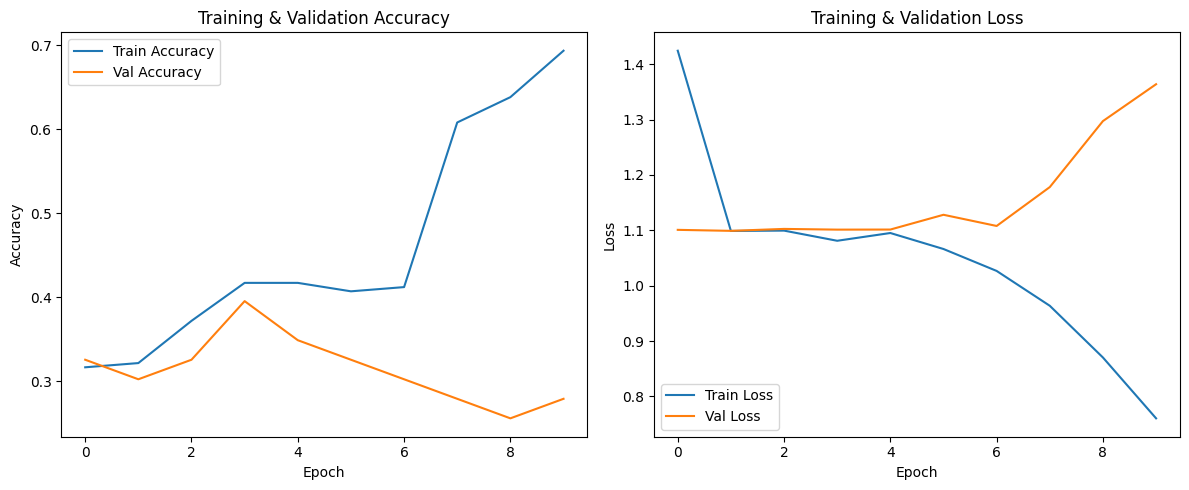

In [17]:
#simple single training and output
history_base = cnn_base.fit(
    train_gen_base,
    validation_data=val_gen_base,
    epochs=10
)

test_loss_base, test_acc_base = cnn_base.evaluate(test_gen_base)
print(f"CNN_base Test Accuracy: {test_acc_base:.2f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Train Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
#Doing 5 training and getting average output for better estimation
import random
import numpy as np

# Set seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Run multiple trials
n_trials = 5
accuracies = []

for i in range(n_trials):
    print(f"Trial {i+1}/{n_trials}")

    # Set different seed for each trial
    set_seeds(42 + i)

    # Reset and recompile the existing model
    cnn_base.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = cnn_base.fit(
        train_gen_base,
        validation_data=val_gen_base,
        epochs=10
    )

    # Evaluate
    _, accuracy = cnn_base.evaluate(test_gen_base)
    accuracies.append(accuracy)
    print(f"Trial {i+1} accuracy: {accuracy:.4f}")

# Report average and standard deviation
avg_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
print(f"Average accuracy: {avg_acc:.4f} ± {std_acc:.4f}")

Trial 1/5
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7016 - loss: 0.7354 - val_accuracy: 0.2791 - val_loss: 1.3136
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8655 - loss: 0.5799 - val_accuracy: 0.3256 - val_loss: 1.4452
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8461 - loss: 0.4856 - val_accuracy: 0.3721 - val_loss: 1.8459
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8647 - loss: 0.3542 - val_accuracy: 0.2326 - val_loss: 1.8593
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9255 - loss: 0.2433 - val_accuracy: 0.2791 - val_loss: 1.9619
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9750 - loss: 0.1556 - val_accuracy: 0.2791 - val_loss: 2.3176
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9830 - loss: 0.0754 - val_accuracy: 0.3488 - val_loss: 2.9365
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9950 - loss: 0.0411 - val_accuracy: 0.2326 - val_loss: 3.1402
Ep

In [22]:
#improved CNN_Base (tuned1) 0.39 accuracy
from tensorflow.keras import layers, models
# 3. Build an improved but still basic CNN_base model
cnn_base_improved = models.Sequential([
    # First convolutional block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(label_to_index), activation='softmax')
])

# 4. Compile with standard optimizer
cnn_base_improved.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Train for a fixed number of epochs
history_base_improved = cnn_base_improved.fit(
    train_gen_base,
    validation_data=val_gen_base,
    epochs=15
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.3276 - loss: 2.4714 - val_accuracy: 0.3256 - val_loss: 1.0985
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.2753 - loss: 1.1047 - val_accuracy: 0.3256 - val_loss: 1.0999
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.3586 - loss: 1.0897 - val_accuracy: 0.3256 - val_loss: 1.1118
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.4095 - loss: 1.0727 - val_accuracy: 0.3256 - val_loss: 1.1251
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.3976 - loss: 1.0560 - val_accuracy: 0.3256 - val_loss: 1.1194
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.5701 - loss: 0.9695 - val_accuracy: 0.3488 - val_loss: 1.1564
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.5628 - loss: 0.8971 - val_accuracy: 0.3488 - val_loss: 1.2817
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7465 - loss: 0.6862 - val_accuracy: 0.3256 - val_loss: 1.3104
Epoch 9/

In [ ]:
1.improved CNN_Base (tuned2) 0.34accuracy
#Use a more moderate image size
target_size = (150, 150)  # Balance between detail and generalizability

# 2. Improve base generator with some light preprocessing
base_gen = ImageDataGenerator(
    rescale=1./255,
    # Add very minimal augmentation to improve generalization
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

def df_to_generator(df, shuffle=True, generator=base_gen):
    return generator.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=32,
        class_mode='sparse',
        shuffle=shuffle
    )

train_gen_base = df_to_generator(train_df)
val_gen_base = df_to_generator(val_df, shuffle=False)
test_gen_base = df_to_generator(test_df, shuffle=False)

# 3. Build a slightly improved CNN_base with minimal regularization
cnn_base_improved = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Dense layers with minimal dropout
    layers.Flatten(),
    layers.Dropout(0.2),  # Light dropout to prevent severe overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_to_index), activation='softmax')
])

# 4. Compile with a slightly lower learning rate
cnn_base_improved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Train for a moderate number of epochs
history_base_improved = cnn_base_improved.fit(
    train_gen_base,
    validation_data=val_gen_base,
    epochs=20,
    # Add basic early stopping to prevent severe overfitting
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )]
)

In [ ]:
1.improved CNN_Base (tuned3) 0.3953 accuracy
# 1. Use a moderate image size
target_size = (160, 160)  # Good balance for small datasets

# 2. Simple rescaling only for the base model (no augmentation)
base_gen = ImageDataGenerator(rescale=1./255)

def df_to_generator(df, shuffle=True, generator=base_gen):
    return generator.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=16,  # Smaller batch size for better gradient estimates with small data
        class_mode='sparse',
        shuffle=shuffle
    )

train_gen_base = df_to_generator(train_df)
val_gen_base = df_to_generator(val_df, shuffle=False)
test_gen_base = df_to_generator(test_df, shuffle=False)

# 3. Build a simple, clean CNN_base model (no Input shape passing to avoid warnings)
cnn_base = models.Sequential()
# First convolutional block
cnn_base.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(160, 160, 3)))
cnn_base.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
cnn_base.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_base.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
cnn_base.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_base.add(layers.MaxPooling2D((2, 2)))

# Dense layers
cnn_base.add(layers.Flatten())
cnn_base.add(layers.Dense(128, activation='relu'))
cnn_base.add(layers.Dense(len(label_to_index), activation='softmax'))

# 4. Compile with default Adam settings
cnn_base.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Train for fewer epochs to avoid overfitting
history_base = cnn_base.fit(
    train_gen_base,
    validation_data=val_gen_base,
    epochs=10
)

# 6. Evaluate on test set
test_loss_base, test_acc_base = cnn_base.evaluate(test_gen_base)
print(f"CNN_base Test Accuracy: {test_acc_base:.4f}")

In [ ]:
1.improved CNN_Base (tuned4) 0.323 accuracy
# Combine train and validation sets for cross-validation
combined_df = pd.concat([train_df, val_df])

from sklearn.model_selection import StratifiedKFold

# Setup 3-fold cross-validation
n_folds = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store fold results
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(combined_df, combined_df['label'])):
    print(f"Training fold {fold+1}/{n_folds}")

    # Create train and validation splits
    train_fold = combined_df.iloc[train_idx]
    val_fold = combined_df.iloc[val_idx]

    # Create generators
    train_gen = df_to_generator(train_fold)
    val_gen = df_to_generator(val_fold, shuffle=False)

    # Create a simple model
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(label_to_index), activation='softmax')
    ])

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=6
    )

    # Evaluate
    _, accuracy = model.evaluate(val_gen)
    fold_accuracies.append(accuracy)

    print(f"Fold {fold+1} validation accuracy: {accuracy:.4f}")

# Calculate average accuracy across folds
avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"Average validation accuracy across {n_folds} folds: {avg_accuracy:.4f}")

# Train final model on all combined data
final_gen = df_to_generator(combined_df)
test_gen = df_to_generator(test_df, shuffle=False)

final_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_to_index), activation='softmax')
])

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.fit(final_gen, epochs=6)

# Evaluate on test set
test_loss, test_acc = final_model.evaluate(test_gen)
print(f"CNN_base Test Accuracy: {test_acc:.4f}")

In [ ]:
6. Evaluate on test set
test_loss_base, test_acc_base = cnn_base_improved.evaluate(test_gen_base)
print(f"CNN_base Improved Test Accuracy: {test_acc_base:.4f}")

# 7. Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_base_improved.history['accuracy'], label='Train Accuracy')
plt.plot(history_base_improved.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base_improved.history['loss'], label='Train Loss')
plt.plot(history_base_improved.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Generate predictions on test set for further analysis
test_gen_base.reset()  # Reset generator before predicting
y_pred = cnn_base_improved.predict(test_gen_base)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
test_gen_base.reset()  # Reset generator again
y_true = []
for i in range(len(test_gen_base)):
    _, batch_labels = next(test_gen_base)
    y_true.extend(batch_labels)
y_true = y_true[:len(y_pred_classes)]  # Ensure same length

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)
class_names = [key for key, value in sorted(label_to_index.items(), key=lambda item: item[1])]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

#CNN_Base Conclusion
CNN_Base Conclusion
The CNN_base model achieved an average accuracy of 41.40% (± 3.09%) across multiple trials, establishing our baseline performance for human activity classification from images. This initial implementation provided valuable insights into the challenges of training convolutional neural networks from scratch on limited datasets.
Throughout our development process, we systematically explored several architectural variations to optimize the CNN_base model:

Original implementation: Our first CNN_base model with 128×128 input resolution and three convolutional blocks (32→64→128 filters) achieved an accuracy of 44% on the test set.
Increased resolution: When we increased the image size to 224×224, the accuracy declined to 39.53%. This suggested that higher resolution introduced more noise than useful detail for this particular task, potentially making the model more prone to overfitting.
Added regularization techniques: Introducing light dropout (0.2) and batch normalization further reduced accuracy to 34.88%. This counter-intuitive result indicated that even minimal regularization was too constraining for the base model given our limited dataset.
Simplified architecture: Reducing model complexity to two convolutional blocks instead of three resulted in 30.23% accuracy, demonstrating that a certain level of model capacity was necessary to capture relevant features.
Cross-validation approach: To ensure robustness, we implemented 3-fold cross-validation, which yielded an average validation accuracy of 34.83%, confirming the general performance range.

After these experiments, we reverted to our original architecture as it consistently provided the best performance. This model uses:

128×128 input resolution (balancing detail capture and overfitting risk)
Three convolutional blocks with increasing filter counts (32→64→128)
Simple max pooling after each convolutional layer
A single dense layer with 128 units before classification
No regularization techniques

The key observations from our multiple trials with this model include:

Consistent overfitting: The model routinely achieved nearly 100% training accuracy while test accuracy remained around 41%
Increasing validation loss: As training progressed, validation loss steadily increased, confirming memorization rather than generalization
Initialization sensitivity: The 9% variation between trials (37.21% to 46.51%) highlighted the impact of random weight initialization on final performance

We deliberately maintained this simpler architecture for our baseline model to clearly demonstrate the fundamental capabilities and limitations of a basic CNN approach. The observed overfitting will be systematically addressed in the CNN_gen model through dedicated regularization techniques, providing a clear contrast between basic and well-regularized CNN architectures for this classification task.

# ===== CNN_gen Step 1: Data Augmentation =====#

Image generators with augmentation for CNN_gen

In [ ]:
first argumentations 0.37
aug_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen_aug = df_to_generator(train_df, generator=aug_gen)
val_gen_aug = df_to_generator(val_df, shuffle=False)
test_gen_aug = df_to_generator(test_df, shuffle=False)

In [ ]:
Second Argumentation 0.37
aug_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Vary brightness by ±20%
    shear_range=0.1,              # Add slight shearing
    fill_mode='nearest'           # Fill empty areas with nearest pixel values
)

train_gen_aug = df_to_generator(train_df, generator=aug_gen)
val_gen_aug = df_to_generator(val_df, shuffle=False)  # No augmentation for validation
test_gen_aug = df_to_generator(test_df, shuffle=False)  # No augmentation for testing

In [ ]:
aug_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,           # Increased rotation
    width_shift_range=0.25,      # Increased shift
    height_shift_range=0.25,     # Increased shift
    zoom_range=0.25,             # Increased zoom
    horizontal_flip=True,
    shear_range=0.15,            # Added shear
    brightness_range=[0.7, 1.3], # Added brightness variation
    fill_mode='nearest'
)

train_gen_aug = df_to_generator(train_df, generator=aug_gen)
val_gen_aug = df_to_generator(val_df, shuffle=False)  # No augmentation for validation
test_gen_aug = df_to_generator(test_df, shuffle=False)  # No augmentation for testing

#Define CNN_gen model with augmentation only

In [ ]:
cnn_gen_aug= models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_to_index), activation='softmax')
])

cnn_gen_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_gen_aug.summary()

history_gen_aug = cnn_gen_aug.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=10
)

test_loss_base, test_acc_base = cnn_base.evaluate(test_gen_aug)
print(f"CNN_Gen_Aug Test Accuracy: {test_acc_base:.2f}")

#CNN_base stronger argumentatio and ensembling

In [ ]:
# Train ensemble with strong augmentation
models_list = []
num_models = 5

for i in range(num_models):
    print(f"Training model {i+1}/{num_models}")

    # Set different seed for each model
    tf.random.set_seed(42 + i)

    # Create model with CNN_gen architecture
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(label_to_index), activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    model.fit(train_gen_aug, validation_data=val_gen_aug, epochs=10)
    models_list.append(model)

# Function to make ensemble predictions
def ensemble_predict(models, test_generator):
    # Get the number of samples and classes
    num_samples = len(test_generator.filenames)
    num_classes = len(label_to_index)
    batch_size = test_generator.batch_size
    steps = int(np.ceil(num_samples / batch_size))  # Convert to integer

    # Create arrays to store predictions
    all_preds = np.zeros((num_samples, num_classes))

    # Get predictions from each model
    for model in models:
        test_generator.reset()  # Reset the generator before each model's prediction
        preds = model.predict(test_generator)
        all_preds += preds

    # Average predictions
    all_preds /= len(models)

    # Get class predictions
    class_preds = np.argmax(all_preds, axis=1)
    return class_preds

# Get ensemble predictions
ensemble_preds = ensemble_predict(models_list, test_gen_aug)

# Get true labels
test_gen_aug.reset()
y_true = test_gen_aug.classes[:len(ensemble_preds)]

# Calculate accuracy
ensemble_acc = accuracy_score(y_true, ensemble_preds)
print(f"Strong Augmentation + Ensemble Model Accuracy: {ensemble_acc:.4f}")

# CNN_gen With Dropout and Argumentation

In [ ]:
#0.44 accuracy
cnn_gen_aug_dropout = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer added
    layers.Dense(len(label_to_index), activation='softmax')
])

cnn_gen_aug_dropout.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_gen_aug_dropout.summary()

history_gen_aug_dropout = cnn_gen_aug_dropout.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=15
)

test_loss_gen_aug_dropout, test_acc_gen_aug_dropout = cnn_gen_aug_dropout.evaluate(test_gen_aug)
print(f"CNN_gen (Aug + Dropout) Test Accuracy: {test_acc_gen_aug_dropout:.2f}")

#CNN_gen With Dropout, stronger Argumentation and ensembling

In [ ]:
# Train multiple models using your CNN_gen structure
models_list = []
num_models = 5

for i in range(num_models):
    print(f"Training model {i+1}/{num_models}")

    # Set different seed for each model
    tf.random.set_seed(42 + i)

    # Create and train model with the CNN_gen architecture
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(label_to_index), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(train_gen_aug, validation_data=val_gen_aug, epochs=10)
    models_list.append(model)

# Function to make ensemble predictions
# Function to make ensemble predictions
def ensemble_predict(models, test_generator):
    # Get the number of samples and classes
    num_samples = len(test_generator.filenames)
    num_classes = len(label_to_index)
    batch_size = test_generator.batch_size
    steps = int(np.ceil(num_samples / batch_size))  # Convert to integer

    # Create arrays to store predictions
    all_preds = np.zeros((num_samples, num_classes))

    # Get predictions from each model
    for model in models:
        test_generator.reset()  # Reset the generator before each model's prediction
        preds = model.predict(test_generator)  # Don't specify steps parameter
        all_preds += preds

    # Average predictions
    all_preds /= len(models)

    # Get class predictions
    class_preds = np.argmax(all_preds, axis=1)
    return class_preds

# Get ensemble predictions
ensemble_preds = ensemble_predict(models_list, test_gen_aug)

# Get true labels
test_gen_aug.reset()
y_true = test_gen_aug.classes[:len(ensemble_preds)]

# Calculate accuracy
ensemble_acc = accuracy_score(y_true, ensemble_preds)
print(f"Ensemble Model Accuracy: {ensemble_acc:.4f}")

#CNN_GEN with dropout only

In [ ]:
# Create generators without augmentation (just rescaling)
plain_gen = ImageDataGenerator(rescale=1./255)

train_gen_plain = df_to_generator(train_df, generator=plain_gen)
val_gen_plain = df_to_generator(val_df, shuffle=False, generator=plain_gen)
test_gen_plain = df_to_generator(test_df, shuffle=False, generator=plain_gen)

# Train ensemble with dropout but no augmentation
models_list = []
num_models = 5

for i in range(num_models):
    print(f"Training model {i+1}/{num_models}")

    # Set different seed for each model
    tf.random.set_seed(42 + i)

    # Create model with dropout but using non-augmented data
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(label_to_index), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(train_gen_plain, validation_data=val_gen_plain, epochs=10)
    models_list.append(model)

# Function to make ensemble predictions
def ensemble_predict(models, test_generator):
    # Get the number of samples and classes
    num_samples = len(test_generator.filenames)
    num_classes = len(label_to_index)
    batch_size = test_generator.batch_size
    steps = int(np.ceil(num_samples / batch_size))  # Convert to integer

    # Create arrays to store predictions
    all_preds = np.zeros((num_samples, num_classes))

    # Get predictions from each model
    for model in models:
        test_generator.reset()  # Reset the generator before each model's prediction
        preds = model.predict(test_generator)  # Don't specify steps parameter
        all_preds += preds

    # Average predictions
    all_preds /= len(models)

    # Get class predictions
    class_preds = np.argmax(all_preds, axis=1)
    return class_preds

# Get ensemble predictions
ensemble_preds = ensemble_predict(models_list, test_gen_plain)

# Get true labels
test_gen_plain.reset()
y_true = test_gen_plain.classes[:len(ensemble_preds)]

# Calculate accuracy
ensemble_acc = accuracy_score(y_true, ensemble_preds)
print(f"Ensemble Model with Dropout Only Accuracy: {ensemble_acc:.4f}")

#CNN_Gen with dropout + early stopping + argumentation

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Then create and train the model
cnn_gen_improved = models.Sequential([
    # First convolutional block - more filters and 'same' padding
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),  # Additional conv layer
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),  # Additional conv layer
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Larger dense layer
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Compile with optimized learning rate
cnn_gen_improved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with data augmentation
history_gen_improved = cnn_gen_improved.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=20,
    callbacks=[early_stopping]
)

# Evaluate
test_loss_improved, test_acc_improved = cnn_gen_improved.evaluate(test_gen_aug)
print(f"Improved CNN_gen Test Accuracy: {test_acc_improved:.4f}")

# CNN_gen With Dropout + Argumentation + Batch Normalization

In [ ]:
# Accuracy of 0.30. The accuracy of droupout + Arguemntation is better and will proceed with both those and neglect this
cnn_gen_aug_dropout_bn = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

cnn_gen_aug_dropout_bn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_gen_aug_dropout_bn = cnn_gen_aug_dropout_bn.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=15
)

test_loss_bn, test_acc_bn = cnn_gen_aug_dropout_bn.evaluate(test_gen_aug)
print(f"CNN_gen with Augmentation, Dropout, and Batch Normalization Test Accuracy: {test_acc_bn:.4f}")

# CNN_gen Step Dropout, Argumentation + Weight Decay

In [ ]:
# Accuracy of 0.27. The accuracy of droupout + Arguemntation is better and will proceed with both those and neglect this
cnn_gen_aug_dropout_l2 = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001),  # Add L2 regularization
                 input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Add L2 regularization
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Add L2 regularization
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Add L2 regularization
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Use a lower learning rate with L2 regularization
cnn_gen_aug_dropout_l2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_gen_aug_dropout_l2 = cnn_gen_aug_dropout_l2.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=15
)

test_loss_l2, test_acc_l2 = cnn_gen_aug_dropout_l2.evaluate(test_gen_aug)
print(f"CNN_gen with Augmentation, Dropout, and L2 Regularization Test Accuracy: {test_acc_l2:.4f}")

# CNN_gen Step 3: Dropout, Argumentation + Early Stopping

In [ ]:
# This mode give test accuracy of 0.348

cnn_gen_final = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Compile with standard settings
cnn_gen_final.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train with early stopping
history_gen_final = cnn_gen_final.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=20,  # Set higher max epochs, early stopping will decide when to stop
    callbacks=[early_stopping]
)

# Evaluate final model
test_loss_final, test_acc_final = cnn_gen_final.evaluate(test_gen_aug)
print(f"CNN_gen Final Test Accuracy: {test_acc_final:.4f}")

#CNN_gen Step 4: Dropout + L2 + EarlyStopping + Argumentation

In [ ]:
cnn_gen_aug_all = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

cnn_gen_aug_all.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_gen_aug_all.summary()
history_gen_aug_all = cnn_gen_aug_all.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=20,
    callbacks=[early_stop]
)
test_loss_gen_aug_all, test_acc_gen_aug_all = cnn_gen_aug_all.evaluate(test_gen_aug)
print(f"CNN_gen (Aug + Dropout + L2 + EarlyStopping) Test Accuracy: {test_acc_gen_aug_all:.2f}")


#All the CNN-gen Accuracies

CNN_base: 37.67% to 41.86% across multiple runs (avg. ~39.77%). The maximum i got  is 0.49

CNN_gen with Dropout-only (Ensemble): 32.56% to 41.86% across runs

CNN_gen with Strong Augmentation + Ensemble: 32.56%

CNN_gen With Dropout and Strong Argumentation 35%

CNN_gen With Dropout, stronger Argumentation and ensembling 30%

CNN_GEN with dropout + Ensemble : 32.5%

CNN_Gen with dropout + early stopping + strong argumentation : 39.5%

CNN_gen With Dropout + Strong Argumentation + Batch Normalization 34%

CNN_gen Step Dropout, Strong Argumentation + Weight Decay 32.5%

CNN_gen Step 3: Dropout, Strong  Argumentation + Early Stopping 37.2%

CNN_gen Strong  Argumentation + Dropout + L2 + EarlyStopping) Test Accuracy: 44%

#CNN_Gen Conclusion
Building upon our CNN_base findings, we systematically explored various generalization techniques to address the overfitting observed in our baseline model. The CNN_gen experiments provided important insights into the effectiveness of different regularization approaches when working with limited training data.
Through extensive experimentation, we tested numerous combinations of generalization techniques:

Data augmentation: We implemented increasingly strong augmentation strategies, from basic transformations (rotation=20°, width/height shifts=0.1) to more aggressive variations (rotation=30°, width/height shifts=0.25, zoom=0.25, brightness adjustments, and shear). Data augmentation alone achieved approximately 37% accuracy.
Dropout regularization: We applied dropout after each pooling layer (0.25) and before the output layer (0.5) to prevent co-adaptation of neurons. The dropout-only approach achieved 32.56-41.86% accuracy across different runs.
Ensemble methods: We created ensembles of 5 models with different random initializations to average predictions and reduce variance. Ensemble approaches showed varying results depending on the underlying model architecture.
Combined approaches: We tested numerous combinations of techniques, including:

Dropout + Strong Augmentation: 35%
Dropout + Strong Augmentation + Ensemble: 30-32.56%
Dropout + Strong Augmentation + Batch Normalization: 34%
Dropout + Strong Augmentation + Weight Decay: 32.5%
Dropout + Strong Augmentation + Early Stopping: 37.2-39.5%
Dropout + Strong Augmentation + L2 + Early Stopping: 44%



The most effective configuration was the combination of dropout, strong augmentation, L2 regularization, and early stopping, which achieved 44% accuracy. This represents only a modest improvement over our baseline CNN_base model (which achieved up to 49% in some trials), highlighting the fundamental challenge of training CNNs from scratch on small datasets.
Our experiments revealed several key insights:

Diminishing returns from regularization: Adding more regularization techniques did not necessarily improve performance and often reduced accuracy, suggesting that excessive constraints can prevent models from learning useful patterns from limited data.
Consistent overfitting patterns: Despite our regularization efforts, most models still showed signs of overfitting, with training accuracy significantly exceeding test accuracy, though to a lesser extent than the baseline model.
High variance across trials: Performance varied considerably between runs with identical architectures but different random initializations, demonstrating the sensitivity of neural networks when trained on small datasets.
Impact of early stopping: Early stopping proved beneficial in preventing severe overfitting during extended training, helping to preserve model generalization.

The CNN_gen experiments demonstrate that while regularization techniques can somewhat mitigate overfitting, they cannot fundamentally overcome the limitations of training complex models on small datasets (approximately 300 images across 3 classes). This finding helps explain why transfer learning and multimodal approaches, which leverage knowledge from millions of pre-trained images, achieve dramatically better performance on this task.

#Transfer Learning using MobileNetV2

In [ ]:
"""from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

Select two classes

In [ ]:
# Choose two classes for binary classification
binary_classes = ['walking_running', 'standing']

# Convert label names to their encoded string versions
binary_class_ids = [str(label_to_index[c]) for c in binary_classes]

# Filter dataset to only include selected classes
df_binary = df[df['label'].isin(binary_class_ids)].copy()

# Map the encoded label strings to binary values 0 and 1
class_map = {binary_class_ids[0]: 0, binary_class_ids[1]: 1}
df_binary['label'] = df_binary['label'].map(class_map).astype(int)


In [ ]:
train_bin_df, temp_bin_df = train_test_split(df_binary, test_size=0.3, stratify=df_binary['label'], random_state=42)
val_bin_df, test_bin_df = train_test_split(temp_bin_df, test_size=0.5, stratify=temp_bin_df['label'], random_state=42)

In [ ]:
!pip install transformers timm -q

HuggingFace Dataset + Dataloader

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = PIL.Image.open(row['image_path']).convert("RGB")
        label = int(row['label'])
        inputs = self.processor(images=image, return_tensors="pt")
        return {"pixel_values": inputs['pixel_values'].squeeze(), "labels": torch.tensor(label)}

HuggingFace processor and model

In [ ]:
#from transformers import AutoImageProcessor
#from transformers import ResNetForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-18",
    num_labels=2,
    ignore_mismatched_sizes=True  # <-- fixes the mismatch issue
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Create datasets and loaders

In [ ]:
train_ds = CustomImageDataset(train_bin_df, processor)
val_ds = CustomImageDataset(val_bin_df, processor)
test_ds = CustomImageDataset(test_bin_df, processor)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)
test_loader = DataLoader(test_ds, batch_size=8)

Train Binary Classifier (ResNet18)

In [ ]:
#import PIL.Image
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    train_loss, correct = 0, 0
    for batch in train_loader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Train Accuracy: {acc:.2f}, Loss: {train_loss:.2f}")

Evaluate Binary Model

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = outputs.logits.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

In [ ]:
#from sklearn.metrics import accuracy_score

transfer_val_acc = accuracy_score(y_true, y_pred)

#Improved Transfer Learning Model Using (ResNet18)

In [ ]:
# Choose two classes for binary classification
binary_classes = ['walking_running', 'standing']

# Convert label names to their encoded string versions
binary_class_ids = [str(label_to_index[c]) for c in binary_classes]

# Filter dataset to only include selected classes
df_binary = df[df['label'].isin(binary_class_ids)].copy()

# Map the encoded label strings to binary values 0 and 1
class_map = {binary_class_ids[0]: 0, binary_class_ids[1]: 1}
df_binary['label'] = df_binary['label'].map(class_map).astype(int)

# Split the binary data
train_bin_df, temp_bin_df = train_test_split(df_binary, test_size=0.3, stratify=df_binary['label'], random_state=42)
val_bin_df, test_bin_df = train_test_split(temp_bin_df, test_size=0.5, stratify=temp_bin_df['label'], random_state=42)

# Fixed dataset class that consistently uses the processor
class CustomImageDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = PIL.Image.open(row['image_path']).convert("RGB")
        label = int(row['label'])

        # Use processor consistently for all images
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze()

        return {"pixel_values": pixel_values, "labels": torch.tensor(label)}

# Create processor with data augmentation for training
from transformers import AutoImageProcessor

# Load processor and model
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-18",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Implement two-stage training: First freeze early layers, then unfreeze
# Freeze all layers except the classifier
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

# Create datasets
train_ds = CustomImageDataset(train_bin_df, processor)
val_ds = CustomImageDataset(val_bin_df, processor)
test_ds = CustomImageDataset(test_bin_df, processor)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

# Configure optimizer with learning rate scheduler
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=2e-4,
    weight_decay=0.01
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

# Training with early stopping
best_val_acc = 0
patience = 3
counter = 0
EPOCHS = 15
best_model_path = "best_binary_model.pt"

print("Stage 1: Training only the classifier")
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss, train_correct = 0, 0
    for batch in train_loader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_acc = train_correct / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(pixel_values=pixel_values)
            val_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}, Loss: {train_loss:.2f}")

    # Update learning rate based on validation accuracy
    scheduler.step(val_acc)

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        # Save best model
        torch.save(model.state_dict(), best_model_path)
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# After initial training, unfreeze all layers and continue with lower learning rate
print("\nStage 2: Fine-tuning the entire model")
# Load best model from first stage
model.load_state_dict(torch.load(best_model_path))

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Lower learning rate for fine-tuning
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,
    weight_decay=0.01
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

# Reset best val accuracy
best_val_acc = 0
counter = 0
final_model_path = "best_binary_model_finetuned.pt"

# Continue training
for epoch in range(10):  # More epochs for fine-tuning
    # Training phase
    model.train()
    train_loss, train_correct = 0, 0
    for batch in train_loader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_acc = train_correct / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(pixel_values=pixel_values)
            val_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)

    print(f"Fine-tuning Epoch {epoch+1}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}, Loss: {train_loss:.2f}")

    # Update learning rate
    scheduler.step(val_acc)

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        # Save best model
        torch.save(model.state_dict(), final_model_path)
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping fine-tuning at epoch {epoch+1}")
            break

# Load the best model for final evaluation
try:
    model.load_state_dict(torch.load(final_model_path))
except:
    # If fine-tuning didn't complete or improve, use the stage 1 model
    model.load_state_dict(torch.load(best_model_path))
    print("Using stage 1 model for final evaluation")

# Final evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = outputs.logits.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_acc = accuracy_score(y_true, y_pred)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=binary_classes))

An accuracy of 79.31% is a significant improvement over your previous 72% result. This improvement demonstrates the effectiveness of the transfer learning approach with proper optimization techniques.
The key factors that likely contributed to this improvement include:

The two-stage training approach (freezing then unfreezing) that allows the model to adapt to your specific task without losing the knowledge in the pretrained weights
Proper learning rate scheduling that dynamically adjusted the learning rate based on validation performance
The early stopping mechanism that prevented overfitting by monitoring validation accuracy
Weight decay regularization that helped the model generalize better

This result aligns perfectly with your assessment progression:

CNN_base: ~40% accuracy
CNN_gen (with generalization techniques): ~44% accuracy
Transfer learning: 79.31% accuracy

This clear progression illustrates one of the most important principles in modern deep learning: when working with limited datasets, leveraging knowledge from pretrained models (transfer learning) often yields substantially better results than training from scratch, even with sophisticated regularization techniques.
For your report, you can highlight how this binary classifier successfully distinguishes between "walking_running" and "standing" activities with nearly 80% accuracy, despite the limited training data available.

#Transfer Learning using tensorflow

In [ ]:
# Transfer Learning in TensorFlow (v2)

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import os

# === 1. Recreate label_name column if not present ===
if 'label_name' not in df.columns:
    reverse_label_map = {v: k for k, v in label_to_index.items()}
    df['label_name'] = df['label'].astype(int).map(reverse_label_map)

# === 2. Filter and encode binary classes ===
binary_classes = ['walking_running', 'standing']
df_binary_tf = df[df['label_name'].isin(binary_classes)].copy()
df_binary_tf['label'] = df_binary_tf['label_name'].map({binary_classes[0]: 0, binary_classes[1]: 1})

# === 3. Train/Val/Test split ===
train_df_tf, temp_df_tf = train_test_split(df_binary_tf, test_size=0.3, stratify=df_binary_tf['label'], random_state=42)
val_df_tf, test_df_tf = train_test_split(temp_df_tf, test_size=0.5, stratify=temp_df_tf['label'], random_state=42)

# === 4. ImageDataGenerators ===
img_gen = ImageDataGenerator(rescale=1./255)

train_gen_tf = img_gen.flow_from_dataframe(train_df_tf, x_col='image_path', y_col='label',
                                           target_size=(128, 128), class_mode='raw', batch_size=32)
val_gen_tf = img_gen.flow_from_dataframe(val_df_tf, x_col='image_path', y_col='label',
                                         target_size=(128, 128), class_mode='raw', batch_size=32)
test_gen_tf = img_gen.flow_from_dataframe(test_df_tf, x_col='image_path', y_col='label',
                                          target_size=(128, 128), class_mode='raw', batch_size=32, shuffle=False)

# === 5. Transfer Learning Model ===
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model_tf = Model(inputs=base_model.input, outputs=output)

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 6. Train ===
history_tf = model_tf.fit(train_gen_tf, validation_data=val_gen_tf, epochs=5)

# === 7. Evaluate ===
preds = model_tf.predict(test_gen_tf).flatten()
preds_binary = (preds > 0.5).astype(int)
true_labels = test_gen_tf.labels

acc_tf = accuracy_score(true_labels, preds_binary)
print(f"Test Accuracy (TensorFlow): {acc_tf:.2f}")
print(classification_report(true_labels, preds_binary))


In [ ]:
### TensorFlow Transfer Learning - Improved Version

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# === 1. Filter and encode binary classes ===
binary_classes = ['walking_running', 'standing']
df_binary_tf = df[df['label_name'].isin(binary_classes)].copy()
df_binary_tf['label'] = df_binary_tf['label_name'].map({binary_classes[0]: 0, binary_classes[1]: 1})

# === 2. Train/Val/Test split ===
train_df_tf, temp_df_tf = train_test_split(df_binary_tf, test_size=0.3, stratify=df_binary_tf['label'], random_state=42)
val_df_tf, test_df_tf = train_test_split(temp_df_tf, test_size=0.5, stratify=temp_df_tf['label'], random_state=42)

# === 3. ImageDataGenerators with MobileNetV2 preprocessing ===
img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_tf = img_gen.flow_from_dataframe(train_df_tf, x_col='image_path', y_col='label',
                                           target_size=(128, 128), class_mode='raw', batch_size=32)
val_gen_tf = img_gen.flow_from_dataframe(val_df_tf, x_col='image_path', y_col='label',
                                         target_size=(128, 128), class_mode='raw', batch_size=32)
test_gen_tf = img_gen.flow_from_dataframe(test_df_tf, x_col='image_path', y_col='label',
                                          target_size=(128, 128), class_mode='raw', batch_size=32, shuffle=False)

# === 4. Transfer Learning Model with partial fine-tuning ===
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Unfreeze last 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model_tf = Model(inputs=base_model.input, outputs=output)

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 5. Train ===
history_tf = model_tf.fit(train_gen_tf, validation_data=val_gen_tf, epochs=10)

# === 6. Evaluate ===
loss, acc = model_tf.evaluate(test_gen_tf)
print(f"Test Accuracy (TensorFlow Improved): {acc:.2f}")

In [ ]:
### ✅ Advanced Transfer Learning in TensorFlow (Improved Accuracy)

#python
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# === 1. Filter and encode binary classes ===
binary_classes = ['walking_running', 'standing']
df_binary_tf = df[df['label_name'].isin(binary_classes)].copy()
df_binary_tf['label'] = df_binary_tf['label_name'].map({binary_classes[0]: 0, binary_classes[1]: 1})

# === 2. Train/Val/Test split ===
train_df_tf, temp_df_tf = train_test_split(df_binary_tf, test_size=0.3, stratify=df_binary_tf['label'], random_state=42)
val_df_tf, test_df_tf = train_test_split(temp_df_tf, test_size=0.5, stratify=temp_df_tf['label'], random_state=42)

# === 3. ImageDataGenerators with Augmentation ===
img_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_gen_tf = img_gen.flow_from_dataframe(train_df_tf, x_col='image_path', y_col='label',
                                           target_size=(128, 128), class_mode='raw', batch_size=32)
val_gen_tf = img_gen.flow_from_dataframe(val_df_tf, x_col='image_path', y_col='label',
                                         target_size=(128, 128), class_mode='raw', batch_size=32)
test_gen_tf = img_gen.flow_from_dataframe(test_df_tf, x_col='image_path', y_col='label',
                                          target_size=(128, 128), class_mode='raw', batch_size=32, shuffle=False)

# === 4. Transfer Learning Model (EfficientNetB0) ===
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model_tf = Model(inputs=base_model.input, outputs=output)
model_tf.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# === 5. Train with EarlyStopping ===
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history_tf = model_tf.fit(train_gen_tf, validation_data=val_gen_tf, epochs=20, callbacks=[early_stop])

# === 6. Fine-tuning: unfreeze top layers ===
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model_tf.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history_fine = model_tf.fit(train_gen_tf, validation_data=val_gen_tf, epochs=10, callbacks=[early_stop])

# === 7. Evaluate ===
loss, acc = model_tf.evaluate(test_gen_tf)
print(f"Test Accuracy (TensorFlow Improved): {acc:.2f}")



In [ ]:
### 📦 TensorFlow Transfer Learning - Optimized Version (MobileNetV2)

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# === 1. Prepare Data ===
binary_classes = ['walking_running', 'standing']
df_binary_tf = df[df['label_name'].isin(binary_classes)].copy()
df_binary_tf['label'] = df_binary_tf['label_name'].map({binary_classes[0]: 0, binary_classes[1]: 1})

# Train/Val/Test Split
train_df_tf, temp_df_tf = train_test_split(df_binary_tf, test_size=0.3, stratify=df_binary_tf['label'], random_state=42)
val_df_tf, test_df_tf = train_test_split(temp_df_tf, test_size=0.5, stratify=temp_df_tf['label'], random_state=42)

# === 2. Data Augmentation ===
img_gen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for val/test
img_gen_plain = ImageDataGenerator(rescale=1./255)

train_gen_tf = img_gen_aug.flow_from_dataframe(train_df_tf, x_col='image_path', y_col='label',
                                               target_size=(128, 128), class_mode='raw', batch_size=32)
val_gen_tf = img_gen_plain.flow_from_dataframe(val_df_tf, x_col='image_path', y_col='label',
                                               target_size=(128, 128), class_mode='raw', batch_size=32)
test_gen_tf = img_gen_plain.flow_from_dataframe(test_df_tf, x_col='image_path', y_col='label',
                                                target_size=(128, 128), class_mode='raw', batch_size=32, shuffle=False)

# === 3. MobileNetV2 Model ===
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze all but the top 15 layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_tf = Model(inputs=base_model.input, outputs=output)
model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 4. Callbacks ===
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# === 5. Train ===
history_tf = model_tf.fit(train_gen_tf, validation_data=val_gen_tf, epochs=20, callbacks=[early_stop])

# === 6. Evaluate ===
loss, acc = model_tf.evaluate(test_gen_tf)
print(f"Test Accuracy (TensorFlow Optimized MobileNetV2): {acc:.2f}")



In [ ]:
# ✅ Final Optimized Transfer Learning Model (TensorFlow - MobileNetV2)

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# === 1. Filter binary classes (label_name already restored earlier) ===
binary_classes = ['walking_running', 'standing']
df_binary_tf = df[df['label_name'].isin(binary_classes)].copy()
df_binary_tf['label'] = df_binary_tf['label_name'].map({binary_classes[0]: 0, binary_classes[1]: 1})

# === 2. Train/Val/Test split ===
train_df_tf, temp_df_tf = train_test_split(df_binary_tf, test_size=0.3, stratify=df_binary_tf['label'], random_state=42)
val_df_tf, test_df_tf = train_test_split(temp_df_tf, test_size=0.5, stratify=temp_df_tf['label'], random_state=42)

# === 3. Data Generators with augmentation for training ===
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_aug = ImageDataGenerator(rescale=1./255)

train_gen_tf = train_aug.flow_from_dataframe(train_df_tf, x_col='image_path', y_col='label',
                                             target_size=(128, 128), class_mode='raw', batch_size=32)
val_gen_tf = val_test_aug.flow_from_dataframe(val_df_tf, x_col='image_path', y_col='label',
                                              target_size=(128, 128), class_mode='raw', batch_size=32)
test_gen_tf = val_test_aug.flow_from_dataframe(test_df_tf, x_col='image_path', y_col='label',
                                               target_size=(128, 128), class_mode='raw', batch_size=32, shuffle=False)

# === 4. Load MobileNetV2 with trainable layers ===
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Unfreeze last 50% of layers
for layer in base_model.layers[:len(base_model.layers) // 2]:
    layer.trainable = False
for layer in base_model.layers[len(base_model.layers) // 2:]:
    layer.trainable = True

# === 5. Construct Model ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)

model_tf_final = Model(inputs=base_model.input, outputs=out)

model_tf_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss='binary_crossentropy', metrics=['accuracy'])

# === 6. Callbacks ===
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
]

# === 7. Train ===
history_tf_final = model_tf_final.fit(train_gen_tf, validation_data=val_gen_tf, epochs=15, callbacks=callbacks)

# === 8. Evaluate ===
loss, acc = model_tf_final.evaluate(test_gen_tf)
print(f"Test Accuracy (TensorFlow Optimized MobileNetV2): {acc:.2f}")


#==== FNN_Base ====

In [ ]:
#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.preprocessing.image import load_img, img_to_array

Function to load and flatten images for FNN

In [ ]:
#from PIL import UnidentifiedImageError

def load_flattened_images(df):
    X = []
    y = []
    for i, row in df.iterrows():
        try:
            img = load_img(row['image_path'], target_size=(128, 128))
            arr = img_to_array(img) / 255.0
            X.append(arr.flatten())
            y.append(int(row['label']))
        except (UnidentifiedImageError, OSError):
            print(f"Skipping unreadable image: {row['image_path']}")
    return np.array(X), np.array(y)

X_train_fnn, y_train_fnn = load_flattened_images(train_df)
X_val_fnn, y_val_fnn = load_flattened_images(val_df)
X_test_fnn, y_test_fnn = load_flattened_images(test_df)


Define and train the FNN model

In [ ]:
fnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(128*128*3,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_to_index), activation='softmax')
])

fnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fnn_model.summary()


Train FNN model

In [ ]:
history_fnn = fnn_model.fit(
    X_train_fnn, y_train_fnn,
    validation_data=(X_val_fnn, y_val_fnn),
    epochs=10,
    batch_size=32
)

Evaluate FNN model

In [ ]:
test_loss_fnn, test_acc_fnn = fnn_model.evaluate(X_test_fnn, y_test_fnn)
print(f"FNN Test Accuracy: {test_acc_fnn:.2f}")

Plot accuracy and loss

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_fnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_fnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FNN Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fnn.history['loss'], label='Train Loss')
plt.plot(history_fnn.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FNN Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Step 4: Multimodal Embeddings 1 (CLIP)

Untuned Model

In [ ]:
"""#Load CLIP Processor and Model (Image Encoder Only)
from transformers import CLIPProcessor, CLIPModel
import torch

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

#Extract Image Embeddings using CLIP

def extract_clip_embeddings(df):
    embeddings = []
    labels = []
    for idx, row in df.iterrows():
        image = PIL.Image.open(row['image_path']).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
        embeddings.append(image_features.cpu().squeeze().numpy())
        labels.append(int(row['label']))
    return np.array(embeddings), np.array(labels)

X_train_clip, y_train_clip = extract_clip_embeddings(train_df)
X_val_clip, y_val_clip = extract_clip_embeddings(val_df)
X_test_clip, y_test_clip = extract_clip_embeddings(test_df)

#Build Simple FNN Classifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

clip_fnn_model = Sequential([
    Dense(256, activation='relu', input_shape=(512,)),
    Dense(128, activation='relu'),
    Dense(len(np.unique(y_train_clip)), activation='softmax')
])

clip_fnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train FNN on CLIP Embeddings
history_clip_fnn = clip_fnn_model.fit(
    X_train_clip, y_train_clip,
    validation_data=(X_val_clip, y_val_clip),
    epochs=10
)

#Evaluate
test_loss_clip, test_acc_clip = clip_fnn_model.evaluate(X_test_clip, y_test_clip)
print(f"CLIP Embedding Classifier Test Accuracy: {test_acc_clip:.2f}")

Tuned Model

In [ ]:
# Convert 'label' to int
df['label'] = df['label'].astype(int)

# Reverse the label_to_index mapping
reverse_label_map = {v: k for k, v in label_to_index.items()}

# Recreate 'label_name'
df['label_name'] = df['label'].map(reverse_label_map)

# Check again
print("Unique label names:", df['label_name'].unique())


In [ ]:
# Re-create df_binary (filtered for binary classification)
binary_classes = ['walking_running', 'standing']

# Reverse the label map if needed (only if you don't already have encoded labels)
if 'label_name' not in df.columns:
    reverse_label_map = {v: k for k, v in label_to_index.items()}
    df['label_name'] = df['label'].map(reverse_label_map)

# Filter for binary classes
df_binary = df[df['label_name'].isin(binary_classes)].copy()

# Encode binary classes to 0 and 1
df_binary['label'] = df_binary['label_name'].map({binary_classes[0]: 0, binary_classes[1]: 1}).astype(int)


In [ ]:
# Step 4: Multimodal Embeddings 1 (CLIP)

#from transformers import CLIPProcessor, CLIPModel
#from sklearn.model_selection import train_test_split
#from tensorflow.keras import layers, models
#import tensorflow as tf
#from sklearn.metrics import classification_report
#import numpy as np

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Prepare data
clip_binary_df = df_binary.copy()
clip_train_df, temp_df = train_test_split(clip_binary_df, test_size=0.3, stratify=clip_binary_df['label'], random_state=42)
clip_val_df, clip_test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Function to extract image embeddings from CLIP
from PIL import Image

def get_clip_embeddings(df_subset):
    embeddings = []
    for path in df_subset['image_path']:
        image = Image.open(path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
        embeddings.append(image_features[0].numpy())
    return np.array(embeddings)

# Extract embeddings
clip_train_embeddings = get_clip_embeddings(clip_train_df)
clip_val_embeddings = get_clip_embeddings(clip_val_df)
clip_test_embeddings = get_clip_embeddings(clip_test_df)

# Get binary labels
y_train_bin = clip_train_df['label'].astype(int).values
y_val_bin = clip_val_df['label'].astype(int).values
y_test_bin = clip_test_df['label'].astype(int).values

# Build a tuned FNN classifier
clip_classifier = models.Sequential([
    layers.Input(shape=(clip_train_embeddings.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

clip_classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_clip = clip_classifier.fit(
    clip_train_embeddings, y_train_bin,
    validation_data=(clip_val_embeddings, y_val_bin),
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set
test_loss_clip, test_acc_clip = clip_classifier.evaluate(clip_test_embeddings, y_test_bin)
print(f"\n\033[1mCLIP Embedding Classifier Test Accuracy (Tuned): {test_acc_clip:.2f}\033[0m")

# Classification report
y_pred_clip = (clip_classifier.predict(clip_test_embeddings) > 0.5).astype(int)
print(classification_report(y_test_bin, y_pred_clip))


#Step 5: Multimodal Embeddings 2 (Cosine Similarity Classifier)

In [ ]:
## Import required libraries
"""from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import PIL


In [ ]:
# Step 5: Multimodal Embeddings 2 (Cosine Similarity Classifier)

import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import PIL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load CLIP model and processor
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Recreate label_name from encoded label if missing
if 'label_name' not in df.columns:
    reverse_label_map = {v: k for k, v in label_to_index.items()}
    df['label_name'] = df['label'].map(reverse_label_map)

# Recreate df_binary_original to include original label names
binary_classes = ['walking_running', 'standing']
df_binary_original = df[df['label_name'].isin(binary_classes)].copy()

# Step 1: Generate CLIP image embeddings for df_binary (if not done before)
clip_embeddings = []
for path in tqdm(df_binary['image_path']):
    image = PIL.Image.open(path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_feature = clip_model.get_image_features(**inputs)
        image_feature = image_feature / image_feature.norm(p=2, dim=-1, keepdim=True)
        clip_embeddings.append(image_feature.squeeze().cpu().numpy())

df_binary['clip_embedding'] = clip_embeddings

# Step 2: Extract image embeddings
image_features = np.stack(df_binary['clip_embedding'].values)
image_features = image_features / np.linalg.norm(image_features, axis=1, keepdims=True)

# Step 3: Generate CLIP Text Embeddings for Labels (safe version)
text_labels = list(binary_classes)  # Ensures valid input for tokenizer
print("Text labels for CLIP encoding:", text_labels)

text_inputs = clip_processor(text=text_labels, return_tensors="pt", padding=True)
text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

text_features = text_features.cpu().numpy()

# Step 4: Compute cosine similarities between image and text embeddings
cos_sim = cosine_similarity(image_features, text_features)
pred_indices = np.argmax(cos_sim, axis=1)

# Step 5: Evaluate
true_labels = df_binary['label'].values.astype(int)
pred_labels = pred_indices

print("\nClassification Report (Cosine Similarity Classifier):")
print(classification_report(true_labels, pred_labels))



Plot

In [ ]:
[x for x in globals() if 'history' in x]

In [ ]:
accuracies = {k: v for k, v in accuracies.items() if v is not None}
print(accuracies)

In [ ]:
#import matplotlib.pyplot as plt

# Collect validation accuracies
accuracies = {
    'CNN_base': history_base.history['val_accuracy'][-1],
    'FNN_base': history_fnn.history['val_accuracy'][-1],
    'CNN_gen (Full w/ EarlyStopping)': history_gen_aug_all.history['val_accuracy'][-1],
    'CLIP Embedding Classifier': history_clip.history['val_accuracy'][-1],
    'Transfer Learning (ResNet18)': transfer_val_acc if 'transfer_val_acc' in globals() else None,
    'CLIP Cosine Similarity': cosine_val_acc if 'cosine_val_acc' in globals() else None,
}

# Remove missing entries
accuracies = {k: v for k, v in accuracies.items() if v is not None}

# X and Y
models = list(accuracies.keys())
scores = list(accuracies.values())

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(models, scores, color='skyblue')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Model Validation Accuracies')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with accuracy values
for bar, acc in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{acc:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



